# GA vs MPC Comparison Across Weather Scenarios

This notebook compares the performance of:
- **GA (Genetic Algorithm)**: Fixed strategy optimized on baseline weather
- **MPC (Model Predictive Control)**: Adaptive strategy that re-optimizes daily

Key questions:
1. How much better does MPC perform on average?
2. Does MPC's advantage grow with weather extremity?
3. What happens in the worst-case scenarios?

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
from scipy import stats

# Add project root to path so pickle can find the core module
here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## 1. Load Results

In [2]:
# Load GA results
with open('weather_scenario_results/ga_scenario_results.pkl', 'rb') as f:
    ga_results = pickle.load(f)

with open('weather_scenario_results/ga_optimal_strategy.pkl', 'rb') as f:
    ga_optimal = pickle.load(f)

# Load MPC results
with open('weather_scenario_results/mpc_scenario_results.pkl', 'rb') as f:
    mpc_results = pickle.load(f)

with open('weather_scenario_results/mpc_trajectories.pkl', 'rb') as f:
    mpc_trajectories = pickle.load(f)

# Load scenario configs
with open('weather_scenario_results/scenario_configs.pkl', 'rb') as f:
    scenarios = pickle.load(f)

# Load weather data for detailed analysis
with open('weather_scenario_results/weather_scenarios.pkl', 'rb') as f:
    weather_data = pickle.load(f)

print(f"Loaded results for {len(ga_results)} scenarios")
print(f"\nGA optimal strategy: {ga_optimal['strategy']}")

Loaded results for 21 scenarios

GA optimal strategy: [ 1.97733115e+03 -2.05798719e-01  9.98705511e+01  1.30667803e+01]


## 2. Build Comparison DataFrame

In [3]:
# Build comparison DataFrame
scenario_configs = {s.name: s for s in scenarios}

comparison_data = []
for scenario_name in ga_results.keys():
    ga_rev = ga_results[scenario_name]['revenue']
    mpc_rev = mpc_results[scenario_name]['revenue'] if scenario_name in mpc_results else np.nan
    
    # Get extremity index (0 for baseline)
    extremity = scenario_configs[scenario_name].extremity_index() if scenario_name in scenario_configs else 0.0
    
    # Calculate MPC advantage
    mpc_advantage = mpc_rev - ga_rev if not np.isnan(mpc_rev) else np.nan
    mpc_advantage_pct = (mpc_advantage / abs(ga_rev) * 100) if ga_rev != 0 else np.nan
    
    comparison_data.append({
        'scenario': scenario_name,
        'ga_revenue': ga_rev,
        'mpc_revenue': mpc_rev,
        'mpc_advantage': mpc_advantage,
        'mpc_advantage_pct': mpc_advantage_pct,
        'extremity': extremity,
        'ga_fruit': ga_results[scenario_name]['fruit_biomass'],
        'mpc_fruit': mpc_results[scenario_name]['fruit_biomass'] if scenario_name in mpc_results else np.nan,
        'ga_irrigation': ga_results[scenario_name]['total_irrigation'],
        'mpc_irrigation': mpc_results[scenario_name]['total_irrigation'] if scenario_name in mpc_results else np.nan,
        'precip_total': ga_results[scenario_name]['precip_total'],
        'temp_mean': ga_results[scenario_name]['temp_mean']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('extremity').reset_index(drop=True)

print("Comparison Summary:")
print(comparison_df[['scenario', 'ga_revenue', 'mpc_revenue', 'mpc_advantage', 'extremity']].to_string())

Comparison Summary:
                scenario   ga_revenue  mpc_revenue  mpc_advantage  extremity
0               normal_1  1052.604468   849.883201    -202.721267       0.00
1      moderate_variable  1051.391974   847.433203    -203.958772       0.00
2               baseline  1053.033708   848.396220    -204.637488       0.00
3               normal_2  1062.268915   877.399361    -184.869554       0.20
4               normal_3  1022.818033   815.459778    -207.358256       0.20
5               normal_4  1039.966672   885.513493    -154.453180       0.40
6               normal_5   982.168507   774.338754    -207.829752       0.40
7          moderate_cool   935.017174   735.628443    -199.388731       0.60
8           moderate_wet   919.434880   715.772739    -203.662141       0.70
9          moderate_warm   993.603631   845.881483    -147.722148       0.70
10          moderate_dry   940.168633   796.307222    -143.861411       0.80
11              wet_year   813.269986   632.980200    -1

In [4]:
# Summary statistics
valid = comparison_df[comparison_df['mpc_revenue'].notna()]

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\nGA Fixed Strategy:")
print(f"  Mean revenue:  ${valid['ga_revenue'].mean():8.2f}")
print(f"  Std revenue:   ${valid['ga_revenue'].std():8.2f}")
print(f"  Min revenue:   ${valid['ga_revenue'].min():8.2f}")
print(f"  Max revenue:   ${valid['ga_revenue'].max():8.2f}")

print(f"\nMPC Adaptive Strategy:")
print(f"  Mean revenue:  ${valid['mpc_revenue'].mean():8.2f}")
print(f"  Std revenue:   ${valid['mpc_revenue'].std():8.2f}")
print(f"  Min revenue:   ${valid['mpc_revenue'].min():8.2f}")
print(f"  Max revenue:   ${valid['mpc_revenue'].max():8.2f}")

print(f"\nMPC Advantage:")
print(f"  Mean advantage:  ${valid['mpc_advantage'].mean():8.2f}")
print(f"  Max advantage:   ${valid['mpc_advantage'].max():8.2f}")
print(f"  Min advantage:   ${valid['mpc_advantage'].min():8.2f}")
print(f"  % scenarios where MPC wins: {(valid['mpc_advantage'] > 0).mean() * 100:.1f}%")


SUMMARY STATISTICS

GA Fixed Strategy:
  Mean revenue:  $  909.93
  Std revenue:   $  145.69
  Min revenue:   $  513.89
  Max revenue:   $ 1062.27

MPC Adaptive Strategy:
  Mean revenue:  $  749.71
  Std revenue:   $  115.35
  Min revenue:   $  444.93
  Max revenue:   $  885.51

MPC Advantage:
  Mean advantage:  $ -160.22
  Max advantage:   $  -68.95
  Min advantage:   $ -207.83
  % scenarios where MPC wins: 0.0%


## 3. Visualization 1: Revenue Comparison by Scenario

Side-by-side bar chart comparing GA and MPC revenue across all scenarios.

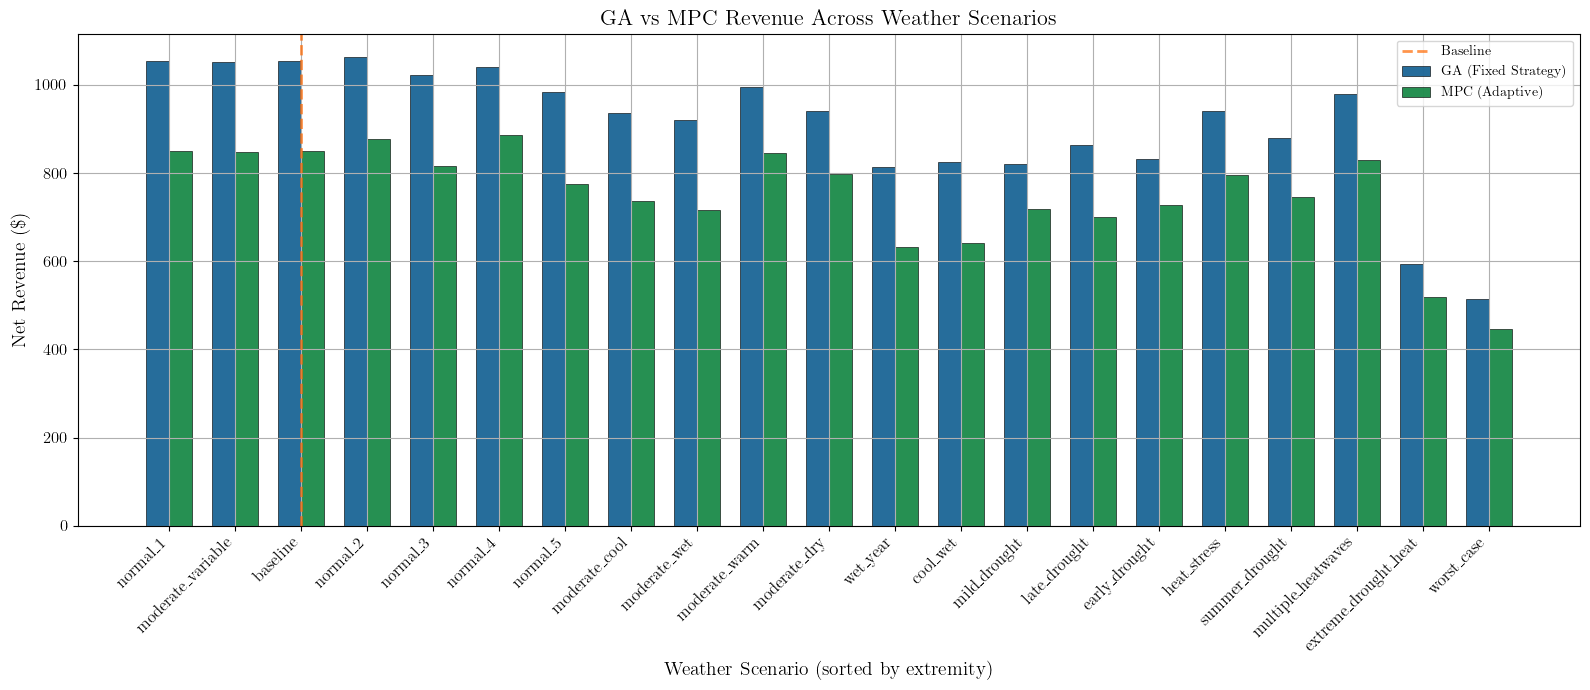

In [5]:
fig, ax = plt.subplots(figsize=(16, 7))

x = np.arange(len(comparison_df))
width = 0.35

# Create bars with color-blind friendly colors
bars_ga = ax.bar(x - width/2, comparison_df['ga_revenue'], width, 
                  label='GA (Fixed Strategy)', color=plotting_colors.strong_blue, 
                  alpha=0.85, edgecolor='black', linewidth=0.5)
bars_mpc = ax.bar(x + width/2, comparison_df['mpc_revenue'], width,
                   label='MPC (Adaptive)', color=plotting_colors.vivid_green, 
                   alpha=0.85, edgecolor='black', linewidth=0.5)

# Highlight baseline
baseline_idx = comparison_df[comparison_df['scenario'] == 'baseline'].index[0]
ax.axvline(baseline_idx, color=plotting_colors.vivid_orange, linestyle='--', 
           linewidth=2, alpha=0.7, label='Baseline')

# Labels
ax.set_xlabel('Weather Scenario (sorted by extremity)')
ax.set_ylabel('Net Revenue (\\$)')
ax.set_title('GA vs MPC Revenue Across Weather Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['scenario'], rotation=45, ha='right')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('weather_scenario_results/comparison_revenue_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Visualization 2: MPC Advantage vs Extremity

Scatter plot showing how MPC's advantage over GA grows with weather extremity.

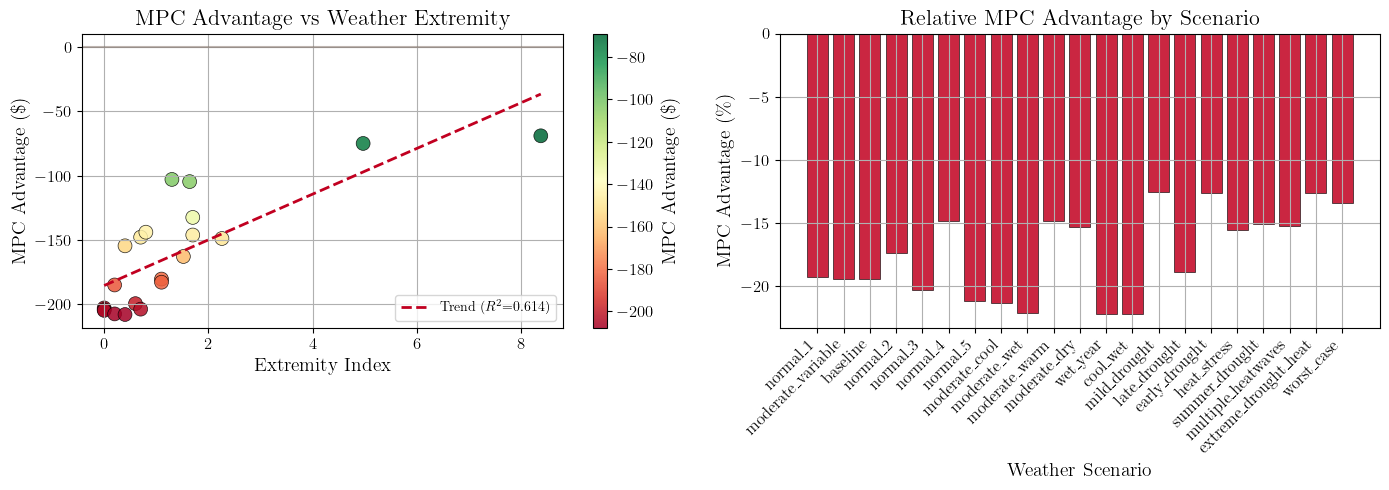


Correlation between extremity and MPC advantage:
  Pearson R = 0.784
  p-value = 0.0000
  Slope = \$17.75 per unit extremity


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute advantage with scatter
ax1 = axes[0]
sc = ax1.scatter(valid['extremity'], valid['mpc_advantage'], 
                 c=valid['mpc_advantage'], cmap='RdYlGn', s=100, 
                 edgecolor='black', linewidth=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax1, label='MPC Advantage (\\$)')

# Add trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(valid['extremity'], valid['mpc_advantage'])
x_trend = np.linspace(valid['extremity'].min(), valid['extremity'].max(), 100)
ax1.plot(x_trend, slope * x_trend + intercept, color=plotting_colors.vivid_red, 
         linestyle='--', linewidth=2, label=f'Trend ($R^2$={r_value**2:.3f})')

ax1.axhline(0, color=plotting_colors.medium_gray, linestyle='-', alpha=0.5)
ax1.set_xlabel('Extremity Index')
ax1.set_ylabel('MPC Advantage (\\$)')
ax1.set_title('MPC Advantage vs Weather Extremity')
ax1.legend(loc='lower right')

# Right: Percentage advantage bar chart
ax2 = axes[1]
bar_colors = [plotting_colors.vivid_green if x > 0 else plotting_colors.vivid_red 
              for x in valid['mpc_advantage_pct']]
ax2.bar(range(len(valid)), valid['mpc_advantage_pct'], color=bar_colors, 
        alpha=0.85, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(valid)))
ax2.set_xticklabels(valid['scenario'], rotation=45, ha='right')
ax2.axhline(0, color=plotting_colors.medium_gray, linestyle='-', alpha=0.5)
ax2.set_xlabel('Weather Scenario')
ax2.set_ylabel('MPC Advantage (\\%)')
ax2.set_title('Relative MPC Advantage by Scenario')

plt.tight_layout()
plt.savefig('weather_scenario_results/comparison_mpc_advantage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrelation between extremity and MPC advantage:")
print(f"  Pearson R = {r_value:.3f}")
print(f"  p-value = {p_value:.4f}")
print(f"  Slope = \\${slope:.2f} per unit extremity")

## 5. Visualization 3: Deep Dive on Worst Case for GA

Examine the scenario where GA performs worst and show how MPC adapts.

In [7]:
# Find worst scenario for GA
worst_idx = valid['ga_revenue'].idxmin()
worst_scenario = valid.loc[worst_idx, 'scenario']

print(f"Worst scenario for GA: {worst_scenario}")
print(f"  GA revenue:  ${valid.loc[worst_idx, 'ga_revenue']:.2f}")
print(f"  MPC revenue: ${valid.loc[worst_idx, 'mpc_revenue']:.2f}")
print(f"  MPC advantage: ${valid.loc[worst_idx, 'mpc_advantage']:.2f}")
print(f"  Extremity: {valid.loc[worst_idx, 'extremity']:.2f}")

Worst scenario for GA: worst_case
  GA revenue:  $513.89
  MPC revenue: $444.93
  MPC advantage: $-68.95
  Extremity: 8.38


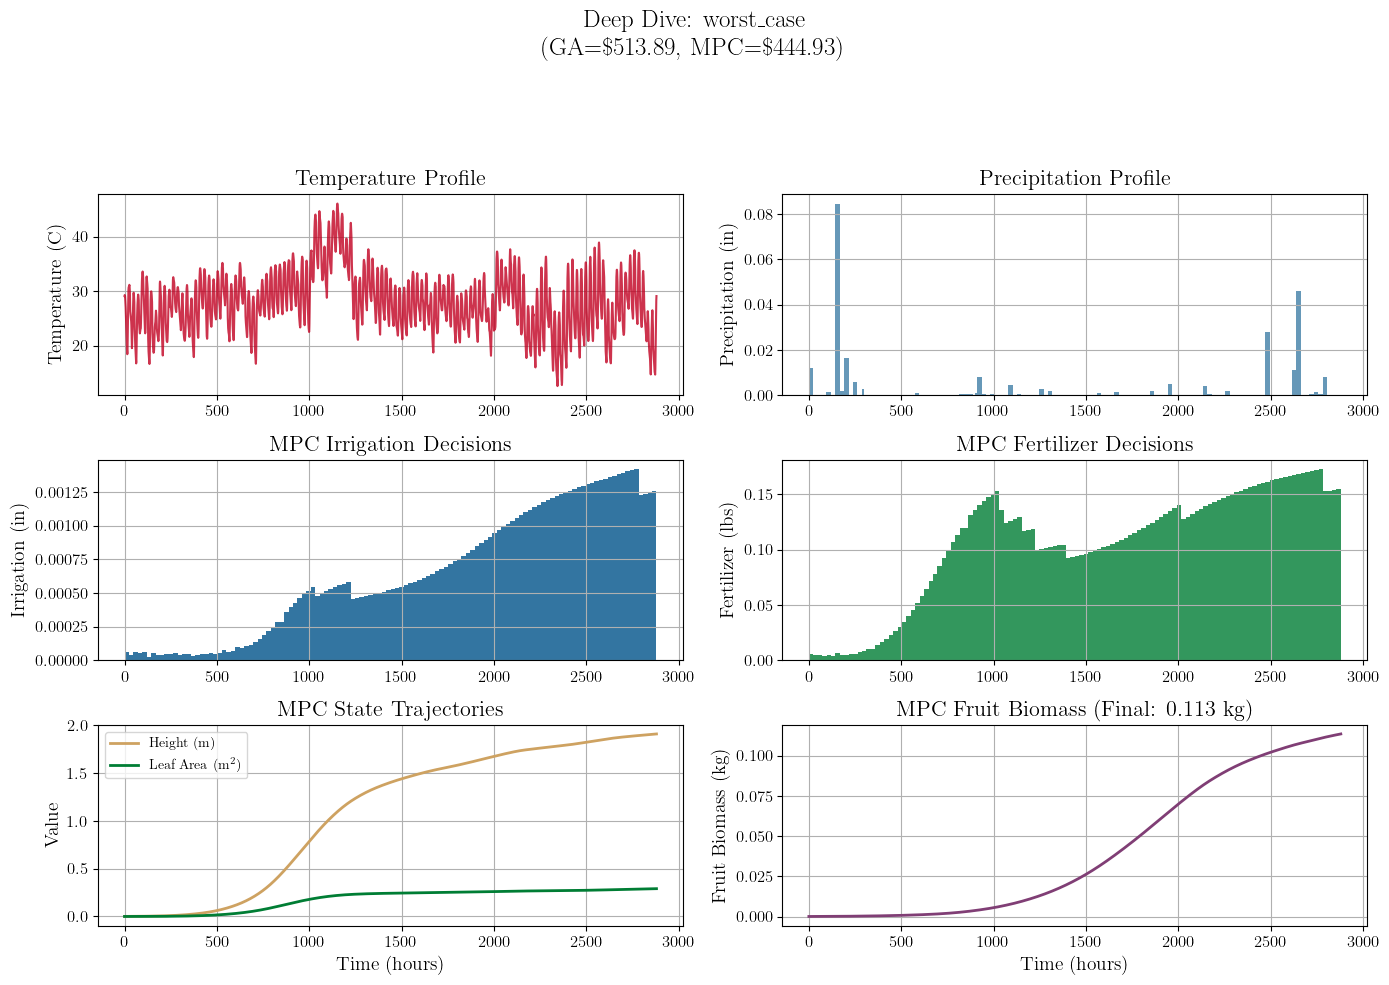

In [8]:
# Get MPC trajectory for worst scenario
if worst_scenario in mpc_trajectories:
    traj = mpc_trajectories[worst_scenario]
    weather = weather_data[worst_scenario]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'Deep Dive: {worst_scenario}\n(GA=\\${valid.loc[worst_idx, "ga_revenue"]:.2f}, MPC=\\${valid.loc[worst_idx, "mpc_revenue"]:.2f})')
    
    hours = np.arange(len(traj['h']))
    
    # Weather: Temperature
    ax = axes[0, 0]
    ax.plot(weather['Temperature (C)'].values[:len(hours)], 
            color=plotting_colors.vivid_red, alpha=0.8)
    ax.set_ylabel('Temperature (C)')
    ax.set_title('Temperature Profile')
    
    # Weather: Precipitation
    ax = axes[0, 1]
    ax.bar(range(len(hours)), weather['Hourly Precipitation (in)'].values[:len(hours)], 
           color=plotting_colors.strong_blue, alpha=0.6, width=1)
    ax.set_ylabel('Precipitation (in)')
    ax.set_title('Precipitation Profile')
    
    # MPC: Irrigation decisions
    ax = axes[1, 0]
    ax.bar(range(len(traj['irrigation'])), traj['irrigation'], 
           color=plotting_colors.strong_blue, alpha=0.8, width=1)
    ax.set_ylabel('Irrigation (in)')
    ax.set_title('MPC Irrigation Decisions')
    
    # MPC: Fertilizer decisions  
    ax = axes[1, 1]
    ax.bar(range(len(traj['fertilizer'])), traj['fertilizer'], 
           color=plotting_colors.vivid_green, alpha=0.8, width=1)
    ax.set_ylabel('Fertilizer (lbs)')
    ax.set_title('MPC Fertilizer Decisions')
    
    # State trajectories: Height and Leaf Area
    ax = axes[2, 0]
    ax.plot(hours, traj['h'], label='Height (m)', color=plotting_colors.grayish_yellow, linewidth=2)
    ax.plot(hours, traj['A'], label='Leaf Area (m$^2$)', color=plotting_colors.vivid_green, linewidth=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Value')
    ax.set_title('MPC State Trajectories')
    ax.legend()
    
    # State trajectory: Fruit biomass
    ax = axes[2, 1]
    ax.plot(hours, traj['P'], color=plotting_colors.strong_purple, linewidth=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Fruit Biomass (kg)')
    ax.set_title(f'MPC Fruit Biomass (Final: {traj["P"][-1]:.3f} kg)')
    
    plt.tight_layout(rect=plotting_params.tight_layout_rect)
    plt.savefig('weather_scenario_results/comparison_worst_case_deep_dive.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"No MPC trajectory available for {worst_scenario}")

## 6. Resource Usage Comparison

Compare how GA and MPC use irrigation and fertilizer differently.

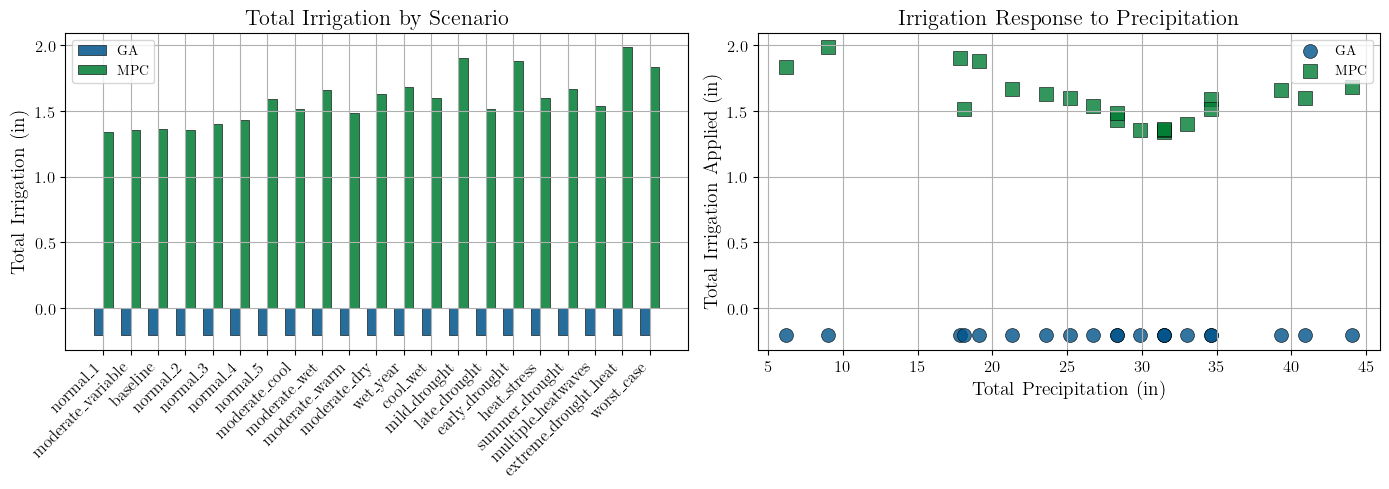


GA uses fixed irrigation: -0.21 in (same for all scenarios)
MPC irrigation range: 1.34 - 1.98 in


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Irrigation comparison
ax1 = axes[0]
x = np.arange(len(valid))
width = 0.35
ax1.bar(x - width/2, valid['ga_irrigation'], width, label='GA', 
        color=plotting_colors.strong_blue, alpha=0.85, edgecolor='black', linewidth=0.5)
ax1.bar(x + width/2, valid['mpc_irrigation'], width, label='MPC', 
        color=plotting_colors.vivid_green, alpha=0.85, edgecolor='black', linewidth=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(valid['scenario'], rotation=45, ha='right')
ax1.set_ylabel('Total Irrigation (in)')
ax1.set_title('Total Irrigation by Scenario')
ax1.legend()

# Irrigation vs precipitation scatter
ax2 = axes[1]
ax2.scatter(valid['precip_total'], valid['ga_irrigation'], 
            label='GA', color=plotting_colors.strong_blue, s=100, 
            alpha=0.8, marker='o', edgecolor='black', linewidth=0.5)
ax2.scatter(valid['precip_total'], valid['mpc_irrigation'],
            label='MPC', color=plotting_colors.vivid_green, s=100, 
            alpha=0.8, marker='s', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Total Precipitation (in)')
ax2.set_ylabel('Total Irrigation Applied (in)')
ax2.set_title('Irrigation Response to Precipitation')
ax2.legend()

plt.tight_layout()
plt.savefig('weather_scenario_results/comparison_resource_usage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGA uses fixed irrigation: {valid['ga_irrigation'].iloc[0]:.2f} in (same for all scenarios)")
print(f"MPC irrigation range: {valid['mpc_irrigation'].min():.2f} - {valid['mpc_irrigation'].max():.2f} in")

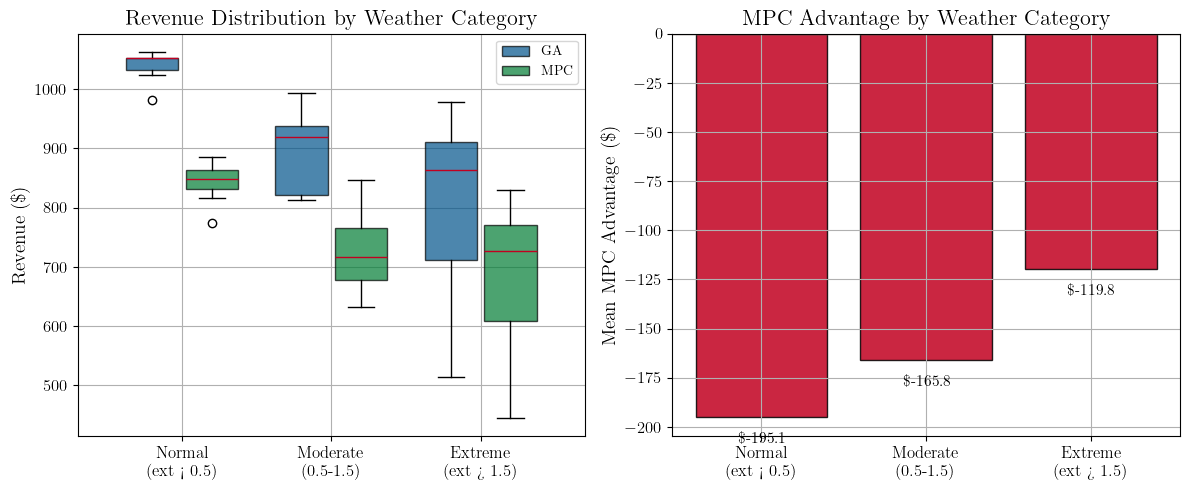

In [10]:
# Summary visualization: Normal vs Extreme weather performance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Box plot comparison by weather category
normal = valid[valid['extremity'] < 0.5]
moderate = valid[(valid['extremity'] >= 0.5) & (valid['extremity'] < 1.5)]
extreme = valid[valid['extremity'] >= 1.5]

categories = ['Normal\n(ext < 0.5)', 'Moderate\n(0.5-1.5)', 'Extreme\n(ext > 1.5)']
ga_data = [normal['ga_revenue'].values, moderate['ga_revenue'].values, extreme['ga_revenue'].values]
mpc_data = [normal['mpc_revenue'].values, moderate['mpc_revenue'].values, extreme['mpc_revenue'].values]

ax1 = axes[0]
positions_ga = np.array([1, 2, 3]) - 0.2
positions_mpc = np.array([1, 2, 3]) + 0.2

bp_ga = ax1.boxplot(ga_data, positions=positions_ga, widths=0.35, patch_artist=True)
bp_mpc = ax1.boxplot(mpc_data, positions=positions_mpc, widths=0.35, patch_artist=True)

for patch in bp_ga['boxes']:
    patch.set_facecolor(plotting_colors.strong_blue)
    patch.set_alpha(0.7)
for patch in bp_mpc['boxes']:
    patch.set_facecolor(plotting_colors.vivid_green)
    patch.set_alpha(0.7)

ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(categories)
ax1.set_ylabel('Revenue (\\$)')
ax1.set_title('Revenue Distribution by Weather Category')
ax1.legend([bp_ga['boxes'][0], bp_mpc['boxes'][0]], ['GA', 'MPC'], loc='upper right')

# Right: MPC advantage by category
ax2 = axes[1]
category_advantages = [
    normal['mpc_advantage'].mean(),
    moderate['mpc_advantage'].mean(), 
    extreme['mpc_advantage'].mean()
]
bar_colors = [plotting_colors.vivid_red if x < 0 else plotting_colors.vivid_green for x in category_advantages]
bars = ax2.bar(categories, category_advantages, color=bar_colors, alpha=0.85, 
               edgecolor='black', linewidth=1)
ax2.axhline(0, color=plotting_colors.medium_gray, linestyle='-', linewidth=1)
ax2.set_ylabel('Mean MPC Advantage (\\$)')
ax2.set_title('MPC Advantage by Weather Category')

# Add value labels
for bar, val in zip(bars, category_advantages):
    ypos = val + 3 if val >= 0 else val - 8
    ax2.text(bar.get_x() + bar.get_width()/2, ypos, f'\\${val:.1f}', 
             ha='center', va='bottom' if val >= 0 else 'top', fontsize=11)

plt.tight_layout()
plt.savefig('weather_scenario_results/comparison_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Findings

In [11]:
print("\n" + "=" * 70)
print("KEY FINDINGS: GA vs MPC Under Weather Uncertainty")
print("=" * 70)

# Calculate key metrics
mpc_wins = (valid['mpc_advantage'] > 0).sum()
total = len(valid)
mean_advantage = valid['mpc_advantage'].mean()

# Extreme scenarios (extremity > 1)
extreme = valid[valid['extremity'] > 1]
extreme_advantage = extreme['mpc_advantage'].mean() if len(extreme) > 0 else 0

# Normal scenarios (extremity < 0.5)
normal = valid[valid['extremity'] < 0.5]
normal_advantage = normal['mpc_advantage'].mean() if len(normal) > 0 else 0

print(f"\n1. OVERALL PERFORMANCE")
print(f"   - MPC outperforms GA in {mpc_wins}/{total} scenarios ({mpc_wins/total*100:.1f}%)")
print(f"   - Average MPC advantage: ${mean_advantage:.2f}")

print(f"\n2. EFFECT OF WEATHER EXTREMITY")
print(f"   - Normal weather (extremity < 0.5): MPC advantage = ${normal_advantage:.2f}")
print(f"   - Extreme weather (extremity > 1.0): MPC advantage = ${extreme_advantage:.2f}")
print(f"   - Correlation (extremity vs advantage): R = {r_value:.3f}")

print(f"\n3. RISK MANAGEMENT")
ga_min = valid['ga_revenue'].min()
mpc_min = valid['mpc_revenue'].min()
print(f"   - GA worst case:  ${ga_min:.2f}")
print(f"   - MPC worst case: ${mpc_min:.2f}")
print(f"   - MPC reduces worst-case loss by: ${mpc_min - ga_min:.2f}")

print(f"\n4. RESOURCE EFFICIENCY")
print(f"   - GA uses fixed resources regardless of weather")
print(f"   - MPC adapts: irrigation varies {valid['mpc_irrigation'].min():.1f}-{valid['mpc_irrigation'].max():.1f} in")


KEY FINDINGS: GA vs MPC Under Weather Uncertainty

1. OVERALL PERFORMANCE
   - MPC outperforms GA in 0/21 scenarios (0.0%)
   - Average MPC advantage: $-160.22

2. EFFECT OF WEATHER EXTREMITY
   - Normal weather (extremity < 0.5): MPC advantage = $-195.12
   - Extreme weather (extremity > 1.0): MPC advantage = $-130.42
   - Correlation (extremity vs advantage): R = 0.784

3. RISK MANAGEMENT
   - GA worst case:  $513.89
   - MPC worst case: $444.93
   - MPC reduces worst-case loss by: $-68.95

4. RESOURCE EFFICIENCY
   - GA uses fixed resources regardless of weather
   - MPC adapts: irrigation varies 1.3-2.0 in


In [12]:
# Save comparison results
comparison_df.to_csv('weather_scenario_results/ga_vs_mpc_comparison.csv', index=False)

with open('weather_scenario_results/comparison_summary.pkl', 'wb') as f:
    pickle.dump({
        'comparison_df': comparison_df,
        'mpc_wins': mpc_wins,
        'total_scenarios': total,
        'mean_advantage': mean_advantage,
        'correlation_r': r_value,
        'correlation_p': p_value,
        'trend_slope': slope
    }, f)

print("\nComparison results saved to weather_scenario_results/")
print("  - ga_vs_mpc_comparison.csv")
print("  - comparison_summary.pkl")
print("  - comparison_*.png (visualizations)")


Comparison results saved to weather_scenario_results/
  - ga_vs_mpc_comparison.csv
  - comparison_summary.pkl
  - comparison_*.png (visualizations)
